In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Summary

I aimed to do this challenge in 4-5 hours. Took me a total of x hours (exception of neural networks). Everything I did in this challenge was to build simple models with a well-thought out process. Did not try any fancy models.

## Assumption
- goal and usd_goal_real are the same column. One is just converted to usd

In [1]:
# All import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from dateutil.relativedelta import relativedelta
from bayes_opt import BayesianOptimization
import math

/Users/joashc/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Read Data

In [2]:
data = pd.read_csv('~/nu_ds_challenge/ml_assignment_data_train.csv')
print('Shape of the dataset is:', data.shape)
data.head()

Shape of the dataset is: (258325, 11)


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26 18:31:19,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27 22:49:51,2,GB,2587.82,failed
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16 17:54:07,3,US,1000.00,failed
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16 00:47:10,49,US,30000.00,failed
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07 17:09:09,165,GB,81349.76,succeeded


# Data Cleaning

- Ensure all columns are the correct dtype
    - 'lauched' and 'deadline' column to datetime dtype


In [3]:
data.dtypes

name              object
category          object
main_category     object
currency          object
deadline          object
goal             float64
launched          object
backers            int64
country           object
usd_goal_real    float64
new_state         object
dtype: object

In [4]:
data_v1 = data.assign(
    deadline = pd.to_datetime(pd.to_datetime(data.deadline).dt.date),
    launched = pd.to_datetime(pd.to_datetime(data.launched).dt.date)
)
data_v1.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,failed
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,failed
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,failed
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,succeeded


- Check for missing values
        - 3 missing values in the name column. Delete these rows as they account for less than 0.1% of the dataset

In [5]:
nulls = pd.DataFrame(data_v1.isnull().sum(), columns=['count_nulls']).sort_values(by=['count_nulls'], ascending=False)
nulls[nulls.count_nulls > 0]

,count_nulls
name,3


In [6]:
# removing rows with missing names
data_v2 = data_v1[data_v1.name.isnull() == False]

- Map output variables [failed, succeeded, surged] to [0,1,2]

In [7]:
data_v2['new_state'] = data_v2.new_state.map({'failed':0,'succeeded':1, 'surged':2 })

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


- Found an invalid entry for country: 'N,0"'. This only occurs when the main_category and category are the same.
    - Eg: main_category: Music, category: Music

In [8]:
print('Invalid entry for country: N,0"')
print('Number of rows with invalid entry are:', data_v2[data_v2['country'] == 'N,0"'].shape[0])      
print(data_v2[['category', 'main_category', 'country']][data_v2['country'] == 'N,0"'].head())

Invalid entry for country: N,0"
Number of rows with invalid entry are: 176
        category main_category country
105        Music         Music    N,0"
572        Music         Music    N,0"
698   Publishing    Publishing    N,0"
1592       Music         Music    N,0"
7615  Technology    Technology    N,0"


- Remove these rows as they account for less than 0.1% of the dataset

In [9]:
data_v3 = data_v2[data_v2['country'] != 'N,0"']
data_v3.shape

(258146, 11)

In [10]:
data_v3.head(1)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.0,0


# Feature Engineering

- For date columns
    - time_period = deadline - launched
    - Month of year launched
    - Year of launch
    - Deadline Year
    - Deadline Month
    - **Months of active: column for each month (1 if active, 0 OW)**
- For name column
    - len of title
    - number of words in the title
    - **(Note: Maybe for future model improvement) Look at the successful or surged titles, remove stop words and make features of the words**
- For category columns
    - Concatenating main category and category as a feature
- For usd_goal_real
    - usd_goal_real/backers: number of dollars per backer
    - usd_goal_real/duration_launched_month: number of usd_goal_real needed to earn per month
    - usd_goal_real/duration_launched_month/backers: number of usd_goal_real needed to earn per month per backer
- For backer column
    - backer/duration_launched_month: number of backers per month the kickstarter was live

In [11]:
# Name features
data_v3['name_length'] = data_v3.name.apply(lambda x: len(x))
data_v3['name_num_words'] = data_v3.name.apply(lambda x: len(x.split()))
data_v3.head()

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0,48,8
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0,29,5
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1,44,7


In [12]:
# Date Features
data_v3 = data_v3.assign(
    launch_month = data_v3.launched.dt.month,
    duration_launched_month = ((data_v3.deadline - data_v3.launched)/np.timedelta64(1, 'M')),
    launch_year = data_v3.launched.dt.year,
    deadline_year = data_v3.deadline.dt.year,
    deadline_month = data_v3.deadline.dt.month
)
data_v3.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7,10,1.182776,2012,2012,12
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4,2,1.971293,2017,2017,4
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0,48,8,8,1.018501,2016,2016,9
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0,29,5,6,1.544180,2013,2013,8
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1,44,7,11,0.985647,2013,2013,12


In [13]:
# Did this feature engineering later so it won't be in knn
# usd_goal_real/backers
data_v3['usd_goal_per_backer'] = np.where(data_v3['backers']>0, 
                                          data_v3['usd_goal_real']/data_v3['backers'],
                                         0)
data_v3.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7,10,1.182776,2012,2012,12,0.00
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4,2,1.971293,2017,2017,4,1293.91


In [14]:
# usd_goal_real/duration_launched_month: number of usd_goal_real needed to earn per month
# backer/duration_launched_month: number of backers per month the kickstarter was live
data_v3 = data_v3.assign(
    usd_goal_per_month = data_v3.usd_goal_real/data_v3.duration_launched_month,
    backers_per_month = data_v3.backers/data_v3.duration_launched_month
)
data_v3.head(1)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,...,name_length,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer,usd_goal_per_month,backers_per_month
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.0,...,34,7,10,1.182776,2012,2012,12,0.0,6763.75,0.0


In [15]:
data_v3['usd_goal_per_month_per_backer'] = np.where(data_v3['backers']>0, 
                                                    ((data_v3['usd_goal_real']/data_v3['duration_launched_month'])
                                                     /data_v3['backers'])
                                                    ,0)
data_v3.head(1)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,...,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer,usd_goal_per_month,backers_per_month,usd_goal_per_month_per_backer
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.0,...,7,10,1.182776,2012,2012,12,0.0,6763.75,0.0,0.0


In [16]:
# Concatenating main category and category as a feature
data_v3['main_category-category'] = data_v3[['main_category', 'category']].apply(lambda x: '-'.join(x), axis=1)
data_v3.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,...,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer,usd_goal_per_month,backers_per_month,usd_goal_per_month_per_backer,main_category-category
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,...,10,1.182776,2012,2012,12,0.00,6763.750000,0.000000,0.000000,Publishing-Fiction
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,...,2,1.971293,2017,2017,4,1293.91,1312.752564,1.014563,656.376282,Journalism-Web


In [17]:
test_data = data_v3.head(2)
test_data

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,...,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer,usd_goal_per_month,backers_per_month,usd_goal_per_month_per_backer,main_category-category
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,...,10,1.182776,2012,2012,12,0.00,6763.750000,0.000000,0.000000,Publishing-Fiction
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,...,2,1.971293,2017,2017,4,1293.91,1312.752564,1.014563,656.376282,Journalism-Web


In [18]:
# %%time
# # inputing month cols
# for index, row in data_v3.iterrows():
#     date1 = row['launched']
#     date2 = row['deadline']
    
#     while date1 < date2:
#         data_v3.loc[index, 'month_' + str(date1.month)] = 1
#         date1 += relativedelta(months=1)

In [19]:
# %%time
# # inputing month_year cols
# for index, row in data_v3.iterrows():
#     date1 = row['launched']
#     date2 = row['deadline']
    
#     while date1 < date2:
#         data_v3.loc[index, 'month_year' + str(date1.month)] = str(1)+'-'+str(date1.year)
#         date1 += relativedelta(months=1)

# EDA

There are a total of 10 features in the dataset. I want to do some quick introductory analysis on each of them so I have a good understand of the distrubution of the dataset. 

First Up: new_state

In [14]:
print('These are the classification variables of the dataset', data_v3.new_state.unique())
class_var = pd.DataFrame(data_v3.new_state.value_counts())
class_var = class_var.assign(percent_class = round(class_var.new_state/258322, 2)*100)
print(class_var)

These are the classification variables of the dataset [0 1 2]
   new_state  percent_class
0     158080           61.0
1      66559           26.0
2      33507           13.0


61%, 26% and 13% of the dataset consist of books that failed, succeeded and surged.


Next: usd_goal_real

Following is a histogram of usd_goal_real (taking out 99th percentile)


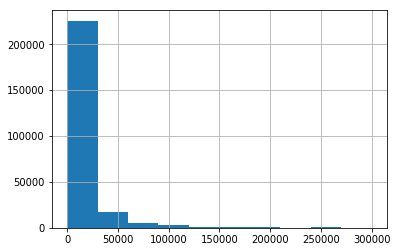

In [15]:
# data_v2.usd_goal_real.hist(bins=10)
print('Following is a histogram of usd_goal_real (taking out 99th percentile)')
data_v3['usd_goal_real'][data_v3['usd_goal_real'] < data_v3['usd_goal_real'].quantile(.99)].hist(bins=10)

Following is a histogram of usd_goal_real less than $50,000


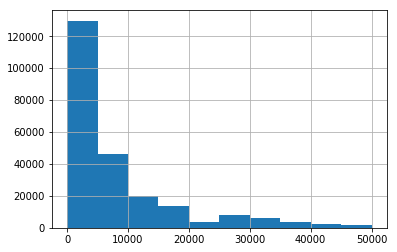

In [16]:
print('Following is a histogram of usd_goal_real less than $50,000')
data_v3['usd_goal_real'][data_v3['usd_goal_real'] < 50000].hist(bins=10)

Based on the histograms above, majority of $ goals are between 0 and 5000

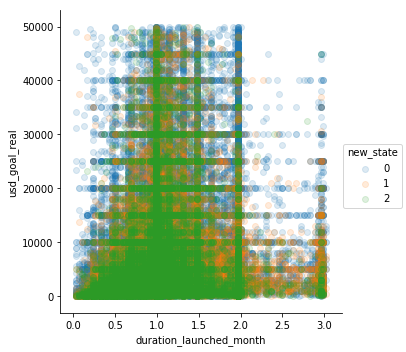

In [17]:
sns.lmplot( x="duration_launched_month", y="usd_goal_real", 
           data=data_v3[(data_v3['usd_goal_real'] < 50000)], 
           fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

Next: Currency

There are 14 different currencies in this dataset.
USD    203749
GBP     22930
EUR     11101
CAD      9609
AUD      5082
Name: currency, dtype: int64


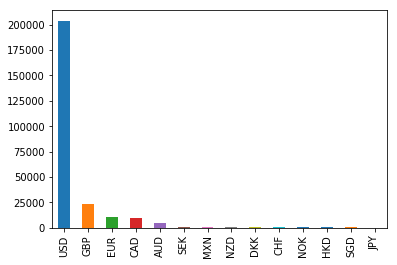

In [18]:
print('There are', data_v3.currency.nunique(), 'different currencies in this dataset.')
print(data_v3.currency.value_counts().head())
data_v3.currency.value_counts().plot(kind="bar")

In the plot above, it is evident that over 75% of the currency in the dataset is USD.


Next: Country

There are 22 different countries in the dataset.
US    203749
GB     22930
CA      9609
AU      5082
DE      2640
Name: country, dtype: int64


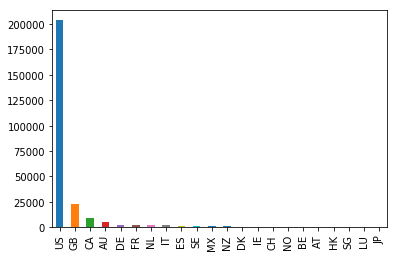

In [19]:
data_v3.country.unique()
print('There are', data_v3.country.nunique(), 'different countries in the dataset.')
print(data_v3.country.value_counts().head())
data_v3.country.value_counts().plot(kind="bar")

The country distribution is similar to the currency distribution

Next: Names of the Books

In [20]:
data_v3.name.nunique()/data_v3.shape[0]
name_counts = pd.DataFrame(data_v3.name.value_counts())
name_counts[name_counts['name'] > 1].shape

print(name_counts[name_counts['name'] > 1].shape[0], 'books in the dataset have duplicate names.',
     'This is', name_counts['name'][name_counts['name'] > 1].sum(), 
      'total rows in the dataset with duplicate book names (', 
      round((1-(data_v3.name.nunique()/data_v3.shape[0])),2)*100,
     '% of the dataset)')

1072 books in the dataset have duplicate names. This is 2430 total rows in the dataset with duplicate book names ( 1.0 % of the dataset)


Next: main_category

There are 15 different main categories.
Here are the t
              main_category
Film & Video          44858
Music                 36415
Publishing            28032
Technology            20673
Games                 20630


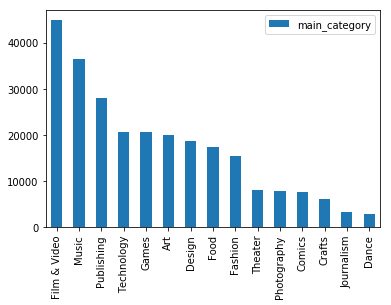

In [21]:
data_v3.main_category.unique()
print('There are', data_v3.main_category.nunique(), 'different main categories.')
main_category_counts = pd.DataFrame(data_v3.main_category.value_counts())
print('Here are the t')
print(main_category_counts.head())
main_category_counts.plot.bar()

For unique book names, I do not think it would add much value to one-hot-encode the names as a feature to the model. There are also very few duplicate names. Thus, other features may have to be extracted from the name which will be done in the feature engineering section of the code!


Next: category

There are a total of 159 categories
Here are the top 5 categories:
                category
Product Design     13723
Documentary        11578
Music               9945
Shorts              9035
Food                8303
Following is a bar plot of the top 20 categories:


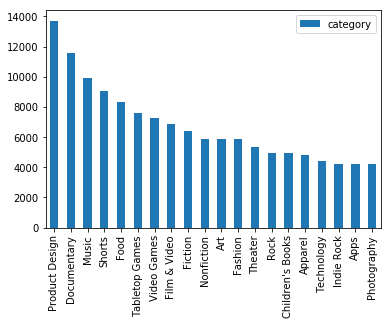

In [22]:
data_v3.category.unique()
print('There are a total of', data_v3.category.nunique(),'categories')
print('Here are the top 5 categories:')
category_counts = pd.DataFrame(data_v3.category.value_counts())
print(category_counts.head())
print('Following is a bar plot of the top 20 categories:')
category_counts.head(20).plot.bar()

Next: launch_year

These are the following counts by year:
   year  count
8  2009    924
7  2010   7619
6  2011  19012
5  2012  30350
4  2013  31946
1  2014  46484
0  2015  50853
2  2016  37861
3  2017  33097


<BarContainer object of 9 artists>

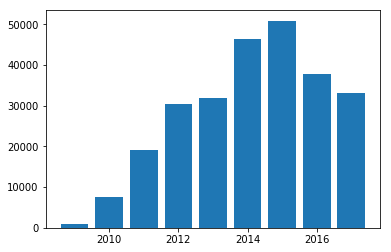

In [24]:
year_counts = (data_v3.launch_year.value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'year', 'launch_year': 'count'})
                )
print('These are the following counts by year:')
print(year_counts)
plt.bar(year_counts['year'], year_counts['count'])

There is an increasing trend in the number of kickstarters year over year till 2015 (peak year). After 2015, there is a drop in the number of kickstarters by more tha 10000.

These are the following counts by month:
    month  count
10      1  18878
9       2  20499
1       3  23408
6       4  22210
3       5  22746
4       6  22578
0       7  24975
5       8  22249
8       9  21333
2      10  22779
7      11  22118
11     12  14373


<BarContainer object of 12 artists>

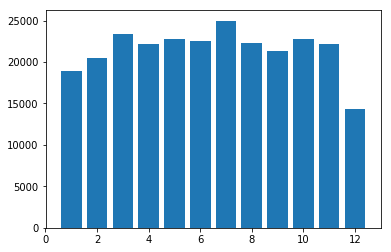

In [26]:
month_counts = (data_v3.launch_month.value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'month', 'launch_month': 'count'})
                )
print('These are the following counts by month:')
print(month_counts)
plt.bar(month_counts['month'], month_counts['count'])

December (14373) has the least number of kickstarter projects launched whereas July (24,975) has the most.


Next: name_length & name_num_words

Histogram of the length of kickstarter names:


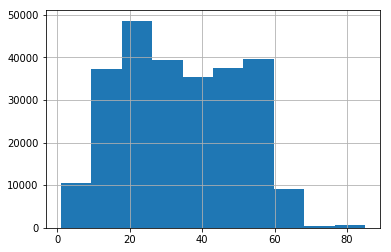

In [27]:
print('Histogram of the length of kickstarter names:')
data_v3.name_length.hist(bins=10)

Histogram of the number of words of kickstarter names:


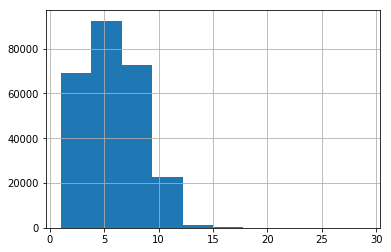

In [28]:
print('Histogram of the number of words of kickstarter names:')
data_v3.name_num_words.hist(bins=10)

Next: backers

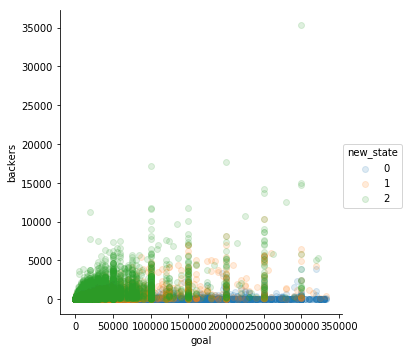

In [30]:
quantile = .99
backers_plot_data = data_v3[data_v3['goal'] < data_v3.goal.quantile(quantile)]
sns.lmplot( x="goal", y="backers", 
           data=backers_plot_data, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

From the plot above, the higher the goal the more likely the kickstarter is to fail. However, if the kickstarter project has a lot of backers, then it is evident to have a higher probability of success.

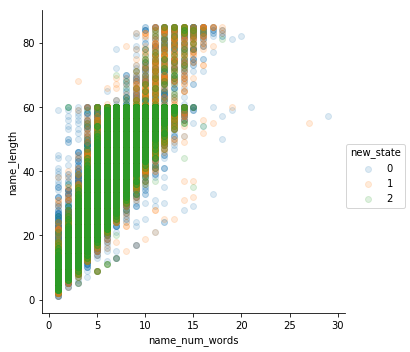

In [31]:
backers_plot_data = data_v3[data_v3['goal'] < data_v3.goal.quantile(quantile)]
sns.lmplot( x="name_num_words", y="name_length", 
           data=backers_plot_data, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

Future improvement
- Correation analysis
- pca on numerical features to see if there is separation with the data
- Change all bar plots to ones with hue of new_state

# Benchmarking
I will be using K-nearest neighbors as a benchmark model. K-NN does not usually provide competitive accuracy in comparision to other more complex supervised machine learning algorithms.

#### Preprocessing Data for K-NN
Specfic features from the dataset will be picked and scaled using MinMaxScaler for the model. The model will be divided into a train and test set. The best K will be picked using GridSearchcv on the train set. The model will then be implemented on the test set to get the benchmarking metrics.

#### Model Performance
Accuracy and log_loss will be used to evaluate model performance.

## K-NN Preprocessing
#### Picking Features
I will use the following features for the K-NN model:


'main_category', 'country', 'backers', 'usd_goal_real', 'launch_month', 'launch_year', 'duration_launched_month'

In [62]:
X = data_v3[['main_category', 'country', 'backers', 'usd_goal_real', 'launch_month', 'launch_year',
             'duration_launched_month']]
y = data_v3[['new_state']]
X.head(2)

,main_category,country,backers,usd_goal_real,launch_month,launch_year,duration_launched_month
0,Publishing,US,0,8000.00,10,2012,1.182776
1,Journalism,GB,2,2587.82,2,2017,1.971293


#### Preprocessing Features
- one hot encode object features

In [64]:
X_dummies = pd.get_dummies(X)
X_dummies.head(2)

,backers,usd_goal_real,launch_month,launch_year,duration_launched_month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,8000.00,10,2012,1.182776,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,2587.82,2,2017,1.971293,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- MinMaxScaler on entire set

In [72]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dummies), columns=X_dummies.columns)
X_scaled.head(2)

,backers,usd_goal_real,launch_month,launch_year,duration_launched_month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0.000000,0.000048,0.818182,0.375,0.384615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000027,0.000016,0.090909,1.000,0.648352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- change the shape of y
- Split data into training and testing set

In [90]:
y = np.array(y).ravel()
y.shape

(258322,)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
print('Shape of training set is:', X_train.shape)
print('Shape of testing set is:', X_test.shape)

Shape of training set is: (206657, 43)
Shape of testing set is: (51665, 43)


#### Train K-NN model
- Using gridsearchcv to try out different ranges of k on the training set

In [97]:
knn_model = KNeighborsClassifier()
knn_model_params = {'n_neighbors': np.arange(1,5)}

In [98]:
# %%time
# knn_model_cv = GridSearchCV(knn_model,param_grid=knn_model_params,cv=3, verbose=3)
# knn_model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=1 ...................................................
[CV] .......... n_neighbors=1, score=0.6553726446592921, total= 2.6min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.6568678686525564, total= 2.4min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.2min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.6546853451404515, total= 2.7min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6775832534912755, total= 2.8min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6793542955027146, total= 2.4min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6777382594178704, total= 2.7min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6709636210550765, total= 2.7min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6720523763899776, total= 2.4min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6711040139362706, total= 2.8min
[CV] n_neighbors=4 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 84.9min finished


CPU times: user 1h 23min 33s, sys: 34.9 s, total: 1h 24min 8s
Wall time: 1h 25min 48s


In [99]:
# print('The best score is:', knn_model_cv.best_score_)
# print('The best k value is:', knn_model_cv.best_params_)

The best score is: 0.6782252718272306
The best k value is: {'n_neighbors': 2}


#### Testing K-NN model
- apply k-nn model on test set


In [101]:
%%time
knn_test = KNeighborsClassifier()
knn_test.fit(X_train,y_train)
knn_predictions = knn_test.predict(X_test)

CPU times: user 3min 54s, sys: 1.61 s, total: 3min 56s
Wall time: 4min 1s


In [125]:
%%time
knn_prob_predictions = knn_test.predict_proba(X_test)

CPU times: user 2min 48s, sys: 717 ms, total: 2min 49s
Wall time: 2min 50s


- Evaluate the model performance

In [127]:
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions))
print("Log_loss:",metrics.log_loss(y_test, knn_prob_predictions))

Accuracy: 0.6866156972805575
Log_loss: 3.5592535094921773


Will use the accuracy of 68.7% and log loss of 3.56 as a benchmark for the model. These benchmark metrics are credible because if every row in the test dataset was predicted as failed, the accuracy would be approximately 61% (61% of the dataset is labeled as failed).


Let's apply a more sophisticated model to see if we can improve these evalution metrics.

# Model Implementation

## Boosting via LightGBM

### Preprocessing Features
- picking features

### Test Model 3 

In [128]:
# numeric_features = ['usd_goal_real', 'backers', 'name_length', 
#                      'name_num_words', 'launch_month', 
#                      'duration_launched_month', 'launch_year','usd_goal_per_backer',
#                    'deadline_year', 'deadline_month']
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']
# numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
#        'name_num_words', 'launch_month', 'duration_launched_month',
#        'launch_year', 'deadline_year', 'deadline_month', 'usd_goal_per_backer',
#        'usd_goal_per_month', 'backers_per_month',
#        'usd_goal_per_month_per_backer', 'month_10', 'month_11', 'month_2',
#        'month_3', 'month_4', 'month_8', 'month_6', 'month_7', 'month_5',
#        'month_9', 'month_1', 'month_12']

categorical_features = ['category', 'main_category', 'country', 'main_category-category']
y = data_v3['new_state']

In [129]:
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [130]:
categorical_data = data_v3[categorical_features]
for col in categorical_data.columns: 
     categorical_data[col] = categorical_data[col].astype('category')

categorical_data.dtypes

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


category                  category
main_category             category
country                   category
main_category-category    category
dtype: object

In [131]:
X_lgbm = pd.concat([numerical_data_scaled.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)

In [132]:
X_data, X_test, y_data, y_test = train_test_split(X_lgbm, y, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train & validation set is: (206516, 18)
Shape of testing set is: (51630, 18)


In [133]:
X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_train.shape)  
print('Shape of testing set is:', X_validate.shape)

Shape of train & validation set is: (165212, 18)
Shape of testing set is: (41304, 18)


In [134]:
params = {'learning_rate':0.09,
         'boosting_type': 'gbdt',
         'num_class':3,
         'objective':'multiclass',
         'metric': 'multi_logloss',
          'max_depth': 10,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'n_estimators': 100,
         'num_leaves': 80,
         'min_split_gain': 0.1,
         'min_child_samples': 20}

In [135]:
lgb_model = lgb.LGBMClassifier(**params, n_jobs=4)
lgb_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.09,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.1,
 'n_estimators': 100,
 'n_jobs': 4,
 'num_leaves': 80,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'num_class': 3,
 'metric': 'multi_logloss'}

In [136]:
lgb_model.fit(X_train, y_train, early_stopping_rounds=200, eval_set=(X_validate, y_validate), eval_metric='multi_logloss')

[1]	valid_0's multi_logloss: 1.00833
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 0.931741
[3]	valid_0's multi_logloss: 0.865852
[4]	valid_0's multi_logloss: 0.808796
[5]	valid_0's multi_logloss: 0.758972
[6]	valid_0's multi_logloss: 0.71524
[7]	valid_0's multi_logloss: 0.676639
[8]	valid_0's multi_logloss: 0.642373
[9]	valid_0's multi_logloss: 0.611984
[10]	valid_0's multi_logloss: 0.584908
[11]	valid_0's multi_logloss: 0.560705
[12]	valid_0's multi_logloss: 0.539126
[13]	valid_0's multi_logloss: 0.519768
[14]	valid_0's multi_logloss: 0.502405
[15]	valid_0's multi_logloss: 0.486782
[16]	valid_0's multi_logloss: 0.472682
[17]	valid_0's multi_logloss: 0.459966
[18]	valid_0's multi_logloss: 0.448513
[19]	valid_0's multi_logloss: 0.438146
[20]	valid_0's multi_logloss: 0.428792
[21]	valid_0's multi_logloss: 0.420303
[22]	valid_0's multi_logloss: 0.412621
[23]	valid_0's multi_logloss: 0.405666
[24]	valid_0's multi_logloss: 0.399341
[25]	valid_0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.09, max_depth=10,
        metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.1, n_estimators=100,
        n_jobs=4, num_class=3, num_leaves=80, objective='multiclass',
        random_state=None, reg_alpha=0.5, reg_lambda=0.5, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [137]:
y_train_pred = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration_)
y_train_pred_proba = lgb_model.predict_proba(X_train, num_iteration=lgb_model.best_iteration_)
print("Train Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("Train Log_loss:",metrics.log_loss(y_train, y_train_pred_proba))

Train Accuracy: 0.8776602183860737
Train Log_loss: 0.29031909253295146


In [142]:
y_pred = lgb_model.predict(X_validate, num_iteration=lgb_model.best_iteration_)
y_pred_proba = lgb_model.predict_proba(X_validate, num_iteration=lgb_model.best_iteration_)
print("Validation Accuracy:",metrics.accuracy_score(y_validate, y_pred))
print("Validation Log_loss:",metrics.log_loss(y_validate, y_pred_proba))

Validation Accuracy: 0.8603525082316482
Validation Log_loss: 0.33462124492849626


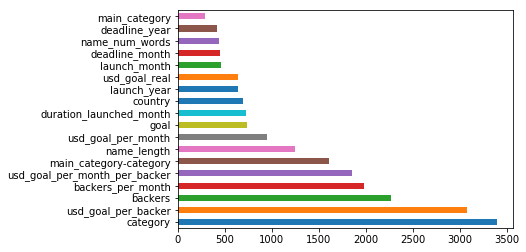

In [143]:
(pd.Series(lgb_model.feature_importances_, index=X_lgbm.columns)
   .nlargest(40)
   .plot(kind='barh')) 

In [144]:
cm = confusion_matrix(y_test, y_pred)
accuracy_per_class = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())*100,
                                 index=['failed', 'succeeded', 'surged'], columns=['accuracy_per_class'])
print('Following is the accuracy per class:')
accuracy_per_class

ValueError: Found input variables with inconsistent numbers of samples: [51630, 41304]

In [145]:
print('Following is the confusion matrix:')
cm_df = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]))*100, index=['actual_failed', 'actual_succeeded', 'actual_surged'],
            columns=['predicted_failed', 'predicted_succeeded', 'predicted_surged'])
cm_df

Following is the confusion matrix:


NameError: name 'cm' is not defined

In [146]:
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
y_pred_proba = lgb_model.predict_proba(X_test, num_iteration=lgb_model.best_iteration_)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Test Log_loss:",metrics.log_loss(y_test, y_pred_proba))

Test Accuracy: 0.8618438892116986
Test Log_loss: 0.3292696080851943


Model does not overfit

### Test Model 3 w SMOTE of Surged Examples

SMOTE only works with numerical data. So I will try only using numerical features to understand if it makes a difference in the accuracy

I want to oversample the surged rows as there are consistently being misclassified with suceeded. To increase the accuracy of the model, I want to use an oversampling technique such as SMOTE to increase the accuracy of the model. Only numerical features are used. 

I have tried two approaches to oversampling. However, the code only shows one approach as I deleted the code


**1)** Over sampling only the surged rows in the training data. I oversampled the surged rows in the training set from 26,818 to 50,000. This increased the accuracy of the training dataset from ~86% to ~88%. But, the testing accuracy dropped to ~83%.

**2)** Over sampling all rows and classes. Training dataset grew from 206,516 to 378,915. The training and testing accuracy reduced from ~87% and ~87% to ~82% and ~83%.

In [147]:
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']

y = data_v3['new_state']
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [148]:
X_data, X_test, y_data, y_test = train_test_split(numerical_data_scaled, y, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train & validation set is: (206516, 14)
Shape of testing set is: (51630, 14)


In [149]:
X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_train.shape)  
print('Shape of testing set is:', X_validate.shape)

Shape of train & validation set is: (165212, 14)
Shape of testing set is: (41304, 14)


In [150]:
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=X_train.columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['new_state'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['new_state']==0]))
print("Number of subscription",len(os_data_y[os_data_y['new_state']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['new_state']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['new_state']==1])/len(os_data_X))

length of oversampled data is  303027
Number of no subscription in oversampled data 101009
Number of subscription 101009
Proportion of no subscription data in oversampled data is  0.3333333333333333
Proportion of subscription data in oversampled data is  0.3333333333333333


In [151]:
lgb_model_v2 = lgb.LGBMClassifier(**params, n_jobs=4)
lgb_model_v2.fit(os_data_X, os_data_y, early_stopping_rounds=200, eval_set=(X_validate, y_validate), eval_metric='multi_logloss')

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 1.01283
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 0.940144
[3]	valid_0's multi_logloss: 0.877777
[4]	valid_0's multi_logloss: 0.823838
[5]	valid_0's multi_logloss: 0.776854
[6]	valid_0's multi_logloss: 0.735675
[7]	valid_0's multi_logloss: 0.699413
[8]	valid_0's multi_logloss: 0.667469
[9]	valid_0's multi_logloss: 0.639209
[10]	valid_0's multi_logloss: 0.614088
[11]	valid_0's multi_logloss: 0.591676
[12]	valid_0's multi_logloss: 0.571719
[13]	valid_0's multi_logloss: 0.553893
[14]	valid_0's multi_logloss: 0.537916
[15]	valid_0's multi_logloss: 0.523627
[16]	valid_0's multi_logloss: 0.510806
[17]	valid_0's multi_logloss: 0.499259
[18]	valid_0's multi_logloss: 0.488889
[19]	valid_0's multi_logloss: 0.479573
[20]	valid_0's multi_logloss: 0.471142
[21]	valid_0's multi_logloss: 0.463586
[22]	valid_0's multi_logloss: 0.456733
[23]	valid_0's multi_logloss: 0.450549
[24]	valid_0's multi_logloss: 0.444943
[25]	valid_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.09, max_depth=10,
        metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.1, n_estimators=100,
        n_jobs=4, num_class=3, num_leaves=80, objective='multiclass',
        random_state=None, reg_alpha=0.5, reg_lambda=0.5, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [152]:
y_train_pred = lgb_model_v2.predict(os_data_X, num_iteration=lgb_model_v2.best_iteration_)
y_train_pred_proba = lgb_model_v2.predict_proba(os_data_X, num_iteration=lgb_model_v2.best_iteration_)
print("Train Accuracy:",metrics.accuracy_score(os_data_y, y_train_pred))
print("Train Log_loss:",metrics.log_loss(os_data_y, y_train_pred_proba))

Train Accuracy: 0.8270946153313071
Train Log_loss: 0.3996658688640294


In [153]:
y_pred = lgb_model_v2.predict(X_validate, num_iteration=lgb_model_v2.best_iteration_)
y_pred_proba = lgb_model_v2.predict_proba(X_validate, num_iteration=lgb_model_v2.best_iteration_)
print("Validation Accuracy:",metrics.accuracy_score(y_validate, y_pred))
print("Validation Log_loss:",metrics.log_loss(y_validate, y_pred_proba))

Validation Accuracy: 0.8386112725159791
Validation Log_loss: 0.3804861321403095


In [154]:
y_pred = lgb_model_v2.predict(X_test, num_iteration=lgb_model_v2.best_iteration_)
y_pred_proba = lgb_model_v2.predict_proba(X_test, num_iteration=lgb_model_v2.best_iteration_)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Test Log_loss:",metrics.log_loss(y_test, y_pred_proba))

Test Accuracy: 0.8408677125702111
Test Log_loss: 0.3753615477963626


## Bayesian Optimization for Test Model Parameter Tuning

In [155]:
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']

categorical_features = ['category', 'main_category', 'country', 'main_category-category']
y = data_v3['new_state']

In [156]:
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [157]:
categorical_data = data_v3[categorical_features]
for col in categorical_data.columns: 
     categorical_data[col] = categorical_data[col].astype('category')

categorical_data.dtypes

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


category                  category
main_category             category
country                   category
main_category-category    category
dtype: object

In [158]:
X_lgbm = pd.concat([numerical_data_scaled.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)

In [159]:
X_data, X_test, y_data, y_test = train_test_split(X_lgbm, y, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train & validation set is: (206516, 18)
Shape of testing set is: (51630, 18)


In [160]:
X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_train.shape)  
print('Shape of testing set is:', X_validate.shape)

Shape of train & validation set is: (165212, 18)
Shape of testing set is: (41304, 18)


In [161]:
def bayes_parameter_opt_lgb(X_train, y_train, X_validate, y_validate, init_round=1, opt_round=1):
    
    def lgb_apply(learning_rate, num_leaves, n_estimators, max_depth, 
                  lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        
        params = {'boosting_type': 'gbdt', 'objective':'multiclass', 'num_class':3}
        params["learning_rate"] = learning_rate
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(math.ceil(n_estimators/100)) * 100
        params['max_depth'] = int(round(max_depth))
        params['reg_alpha'] = max(lambda_l1, 0)
        params['reg_lambda'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = int(math.ceil(min_child_weight/100)) * 100
        
        lgb_model = lgb.LGBMClassifier(**params, n_jobs=4)
        lgb_model.fit(X_train, y_train, early_stopping_rounds=200, 
                      eval_set=(X_test, y_test), 
                      eval_metric='multi_logloss')
        
        y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
        
        return metrics.accuracy_score(y_test, y_pred)
    
    
    lgb_bayesian_params = BayesianOptimization(lgb_apply, pbounds={'learning_rate': (0.1, 0.9), 
                                                       'n_estimators': (400,1000), 
                                                       'num_leaves': (400, 1000),
                                                       'max_depth': (60, 100),
                                                       'lambda_l1': (0.1, 1.0),
                                                       'lambda_l2': (0.1, 4.0),
                                                       'min_split_gain': (0.1, 0.4),
                                                       'min_child_weight': (200,500)})
    
    lgb_bayesian_params.maximize(init_points=int(init_round), n_iter=int(opt_round))
#     lgb_bayesian_params.to_csv("~/data/bayes_opt_result.csv")
    return lgb_bayesian_params
#     return lgb_bayesian_params.res['max']['max_params']
    

In [162]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, X_validate, y_validate, init_round=1, opt_round=1)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   lambda_l1 |   lambda_l2 |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   n_estimators |   num_leaves | 
[1]	valid_0's multi_logloss: 0.544274	valid_0's multi_logloss: 0.544274
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 0.419088	valid_0's multi_logloss: 0.419088
[3]	valid_0's multi_logloss: 0.370757	valid_0's multi_logloss: 0.370757
[4]	valid_0's multi_logloss: 0.350347	valid_0's multi_logloss: 0.350347
[5]	valid_0's multi_logloss: 0.341104	valid_0's multi_logloss: 0.341104
[6]	valid_0's multi_logloss: 0.337107	valid_0's multi_logloss: 0.337107
[7]	valid_0's multi_logloss: 0.335541	valid_0's multi_logloss: 0.335541
[8]	valid_0's multi_logloss: 0.334605	valid_0's multi_logloss: 0.334605
[9]	valid_0's multi_l

[112]	valid_0's multi_logloss: 0.350241	valid_0's multi_logloss: 0.350241
[113]	valid_0's multi_logloss: 0.350443	valid_0's multi_logloss: 0.350443
[114]	valid_0's multi_logloss: 0.350399	valid_0's multi_logloss: 0.350399
[115]	valid_0's multi_logloss: 0.350669	valid_0's multi_logloss: 0.350669
[116]	valid_0's multi_logloss: 0.350746	valid_0's multi_logloss: 0.350746
[117]	valid_0's multi_logloss: 0.350929	valid_0's multi_logloss: 0.350929
[118]	valid_0's multi_logloss: 0.351011	valid_0's multi_logloss: 0.351011
[119]	valid_0's multi_logloss: 0.35116	valid_0's multi_logloss: 0.35116
[120]	valid_0's multi_logloss: 0.351344	valid_0's multi_logloss: 0.351344
[121]	valid_0's multi_logloss: 0.351541	valid_0's multi_logloss: 0.351541
[122]	valid_0's multi_logloss: 0.351732	valid_0's multi_logloss: 0.351732
[123]	valid_0's multi_logloss: 0.35184	valid_0's multi_logloss: 0.35184
[124]	valid_0's multi_logloss: 0.352062	valid_0's multi_logloss: 0.352062
[125]	valid_0's multi_logloss: 0.352108	va

[6]	valid_0's multi_logloss: 0.336385	valid_0's multi_logloss: 0.336385
[7]	valid_0's multi_logloss: 0.335547	valid_0's multi_logloss: 0.335547
[8]	valid_0's multi_logloss: 0.335388	valid_0's multi_logloss: 0.335388
[9]	valid_0's multi_logloss: 0.335055	valid_0's multi_logloss: 0.335055
[10]	valid_0's multi_logloss: 0.335145	valid_0's multi_logloss: 0.335145
[11]	valid_0's multi_logloss: 0.334957	valid_0's multi_logloss: 0.334957
[12]	valid_0's multi_logloss: 0.334864	valid_0's multi_logloss: 0.334864
[13]	valid_0's multi_logloss: 0.334969	valid_0's multi_logloss: 0.334969
[14]	valid_0's multi_logloss: 0.335182	valid_0's multi_logloss: 0.335182
[15]	valid_0's multi_logloss: 0.335523	valid_0's multi_logloss: 0.335523
[16]	valid_0's multi_logloss: 0.335531	valid_0's multi_logloss: 0.335531
[17]	valid_0's multi_logloss: 0.335371	valid_0's multi_logloss: 0.335371
[18]	valid_0's multi_logloss: 0.335497	valid_0's multi_logloss: 0.335497
[19]	valid_0's multi_logloss: 0.335715	valid_0's multi_

[121]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[122]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[123]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[124]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[125]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[126]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[127]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[128]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[129]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[130]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[131]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[132]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[133]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[134]	valid_0's multi_logloss: 0.33916

In [163]:
opt_params.res['max']

{'max_val': 0.8606817741623087,
 'max_params': {'learning_rate': 0.8452193147776897,
  'n_estimators': 975.2053168635805,
  'num_leaves': 512.281120492506,
  'max_depth': 96.68159655124637,
  'lambda_l1': 0.6359469388237938,
  'lambda_l2': 1.5989495850645994,
  'min_split_gain': 0.3270589793835691,
  'min_child_weight': 382.14300153947573}}

In [ ]:
# 0.8627348440828976
# {'learning_rate': 0.1386500136508193,
#  'n_estimators': 358.05178999366126,
#  'num_leaves': 411.83694928592564,
#  'max_depth': 58.410142023835064,
#  'lambda_l1': 0.9946285477898449,
#  'lambda_l2': 3.6479877739422446,
#  'min_split_gain': 0.3772608807213311,
#  'min_child_weight': 193.91574405974183}


# {'max_val': 0.863257795855123,
#  'max_params': {'learning_rate': 0.27201596157942154,
#   'n_estimators': 993.3688372520834,
#   'num_leaves': 574.7187524038648,
#   'max_depth': 62.488789829408745,
#   'lambda_l1': 0.3493254134565104,
#   'lambda_l2': 0.10893183989673129,
#   'min_split_gain': 0.2238516674953104,
#   'min_child_weight': 359.24528857050746}}

### Final Model Implementation TO DOO STILL

In [76]:
# numeric_features = ['usd_goal_real', 'backers', 'name_length', 
#                      'name_num_words', 'launch_month', 
#                      'duration_launched_month', 'launch_year','usd_goal_per_backer',
#                    'deadline_year', 'deadline_month']
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']
# numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
#        'name_num_words', 'launch_month', 'duration_launched_month',
#        'launch_year', 'deadline_year', 'deadline_month', 'usd_goal_per_backer',
#        'usd_goal_per_month', 'backers_per_month',
#        'usd_goal_per_month_per_backer', 'month_10', 'month_11', 'month_2',
#        'month_3', 'month_4', 'month_8', 'month_6', 'month_7', 'month_5',
#        'month_9', 'month_1', 'month_12']

categorical_features = ['category', 'main_category', 'country', 'main_category-category']
y = data_v3['new_state']

In [77]:
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [78]:
categorical_data = data_v3[categorical_features]
for col in categorical_data.columns: 
     categorical_data[col] = categorical_data[col].astype('category')

categorical_data.dtypes

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


category                  category
main_category             category
country                   category
main_category-category    category
dtype: object

In [79]:
X_lgbm = pd.concat([numerical_data_scaled.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)

In [80]:
X_data, X_test, y_data, y_test = train_test_split(X_lgbm, y, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of training set is: (206516, 18)
Shape of testing set is: (51630, 18)


In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_train.shape)  
print('Shape of testing set is:', X_validate.shape)

In [81]:
params = {'learning_rate':0.09,
         'boosting_type': 'gbdt',
         'num_class':3,
         'objective':'multiclass',
         'metric': 'multi_logloss',
          'max_depth': 10,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'n_estimators': 100,
         'num_leaves': 80,
         'min_split_gain': 0.1,
         'min_child_samples': 20}

In [82]:
lgb_model = lgb.LGBMClassifier(**params, n_jobs=4)
lgb_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.09,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.1,
 'n_estimators': 100,
 'n_jobs': 4,
 'num_leaves': 80,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'num_class': 3,
 'metric': 'multi_logloss'}

In [83]:
lgb_model.fit(X_train, y_train, early_stopping_rounds=200, eval_set=(X_validate, y_validate), eval_metric='multi_logloss')

[1]	valid_0's multi_logloss: 1.00798
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 0.931004
[3]	valid_0's multi_logloss: 0.86482
[4]	valid_0's multi_logloss: 0.807444
[5]	valid_0's multi_logloss: 0.757321
[6]	valid_0's multi_logloss: 0.713275
[7]	valid_0's multi_logloss: 0.674466
[8]	valid_0's multi_logloss: 0.64005
[9]	valid_0's multi_logloss: 0.609486
[10]	valid_0's multi_logloss: 0.582243
[11]	valid_0's multi_logloss: 0.557928
[12]	valid_0's multi_logloss: 0.536115
[13]	valid_0's multi_logloss: 0.516599
[14]	valid_0's multi_logloss: 0.499013
[15]	valid_0's multi_logloss: 0.483241
[16]	valid_0's multi_logloss: 0.469035
[17]	valid_0's multi_logloss: 0.456229
[18]	valid_0's multi_logloss: 0.444614
[19]	valid_0's multi_logloss: 0.434123
[20]	valid_0's multi_logloss: 0.424688
[21]	valid_0's multi_logloss: 0.416144
[22]	valid_0's multi_logloss: 0.40839
[23]	valid_0's multi_logloss: 0.401358
[24]	valid_0's multi_logloss: 0.39497
[25]	valid_0's 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.09, max_depth=10,
        metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.1, n_estimators=100,
        n_jobs=4, num_class=3, num_leaves=80, objective='multiclass',
        random_state=None, reg_alpha=0.5, reg_lambda=0.5, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [84]:
y_train_pred = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration_)
y_train_pred_proba = lgb_model.predict_proba(X_train, num_iteration=lgb_model.best_iteration_)
print("Train Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("Train Log_loss:",metrics.log_loss(y_train, y_train_pred_proba))

Train Accuracy: 0.8759224466869395
Train Log_loss: 0.29455505866636644


In [85]:
y_pred = lgb_model.predict(X_validate, num_iteration=lgb_model.best_iteration_)
y_pred_proba = lgb_model.predict_proba(X_validate, num_iteration=lgb_model.best_iteration_)
print("Validation Accuracy:",metrics.accuracy_score(y_validate, y_pred))
print("Validation Log_loss:",metrics.log_loss(y_validate, y_pred_proba))

Test Accuracy: 0.8619601007166376
Test Log_loss: 0.328009494081602


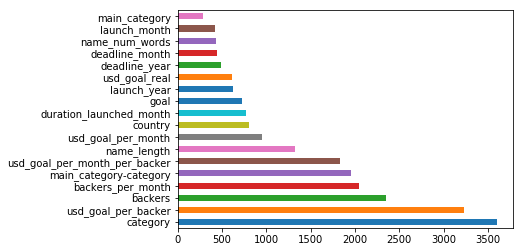

In [87]:
(pd.Series(lgb_model.feature_importances_, index=X_lgbm.columns)
   .nlargest(40)
   .plot(kind='barh')) 

In [88]:
cm = confusion_matrix(y_test, y_pred_v1)
accuracy_per_class = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())*100,
                                 index=['failed', 'succeeded', 'surged'], columns=['accuracy_per_class'])
print('Following is the accuracy per class:')
accuracy_per_class

Following is the accuracy per class:


,accuracy_per_class
failed,94.624705
succeeded,79.700676
surged,58.950986


In [89]:
print('Following is the confusion matrix:')
cm_df = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]))*100, index=['actual_failed', 'actual_succeeded', 'actual_surged'],
            columns=['predicted_failed', 'predicted_succeeded', 'predicted_surged'])
cm_df

Following is the confusion matrix:


,predicted_failed,predicted_succeeded,predicted_surged
actual_failed,94.624705,5.019670,0.355625
actual_succeeded,11.099293,79.700676,9.200030
actual_surged,3.003586,38.045427,58.950986


In [ ]:
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
y_pred_proba = lgb_model.predict_proba(X_test, num_iteration=lgb_model.best_iteration_)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Test Log_loss:",metrics.log_loss(y_test, y_pred_proba))

Improvements
- Benchmarking took too long using K-NN. Next time benchmarking can be done by mapping a predictions to a simple function using the distributions of the dataset. 
    - Eg: Derive a random number for each row in the dataset. If the random number is between [0,60], [61,87] and [87,100], predict classes failed, succeeded and surged.
- Due to time constraint, I trained the k-nn model based on accuracy instead of log_loss (Cross Entropy)
- Model could have been split based on temporal features such as date
- Over sampling class 2 or surged to see if it would give better model performance
- print out classification error per class!